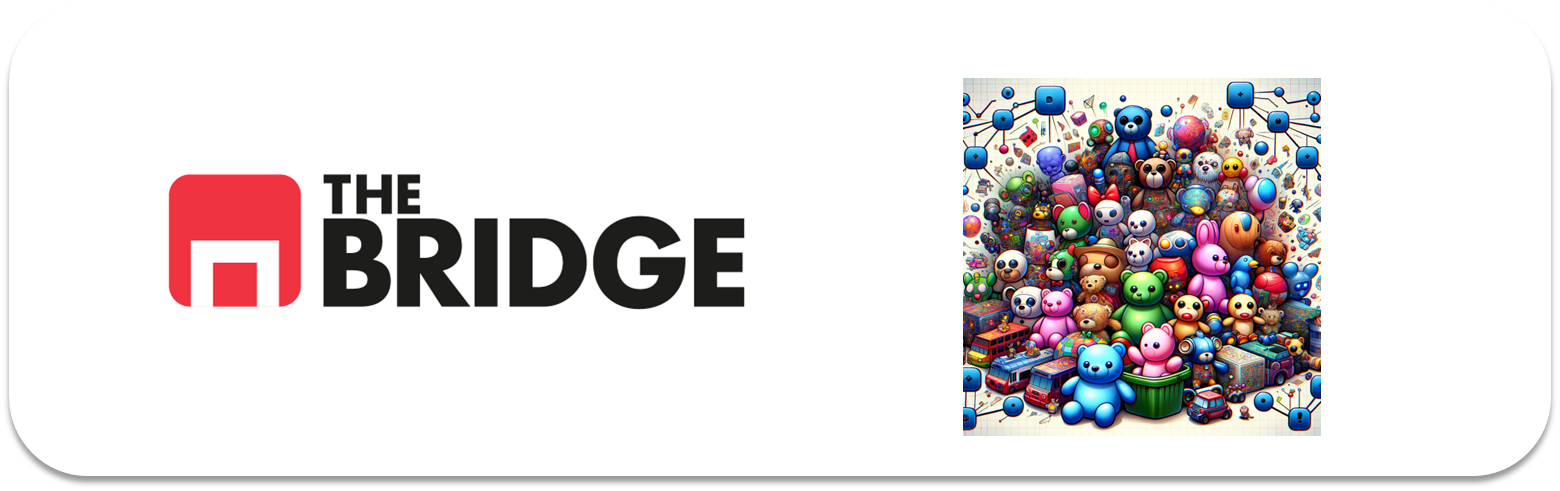

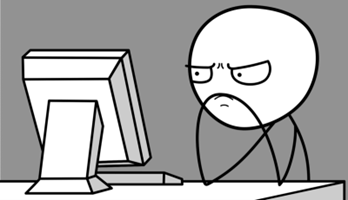

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [5]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns


from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [6]:
df = pd.read_csv('./data/empowering_drinks.csv', sep="|")
df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [7]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


-> no  hay nulos, son todas numericas.  
- hay muy pocas entradas, asi que ademas del DBSCAN, vamos a usar el clustering jerarquico, ademas se quiere entender las relaciones entre clusters asi que no hay duda de que hay que usar este tipo de clustering.

(5, 2)


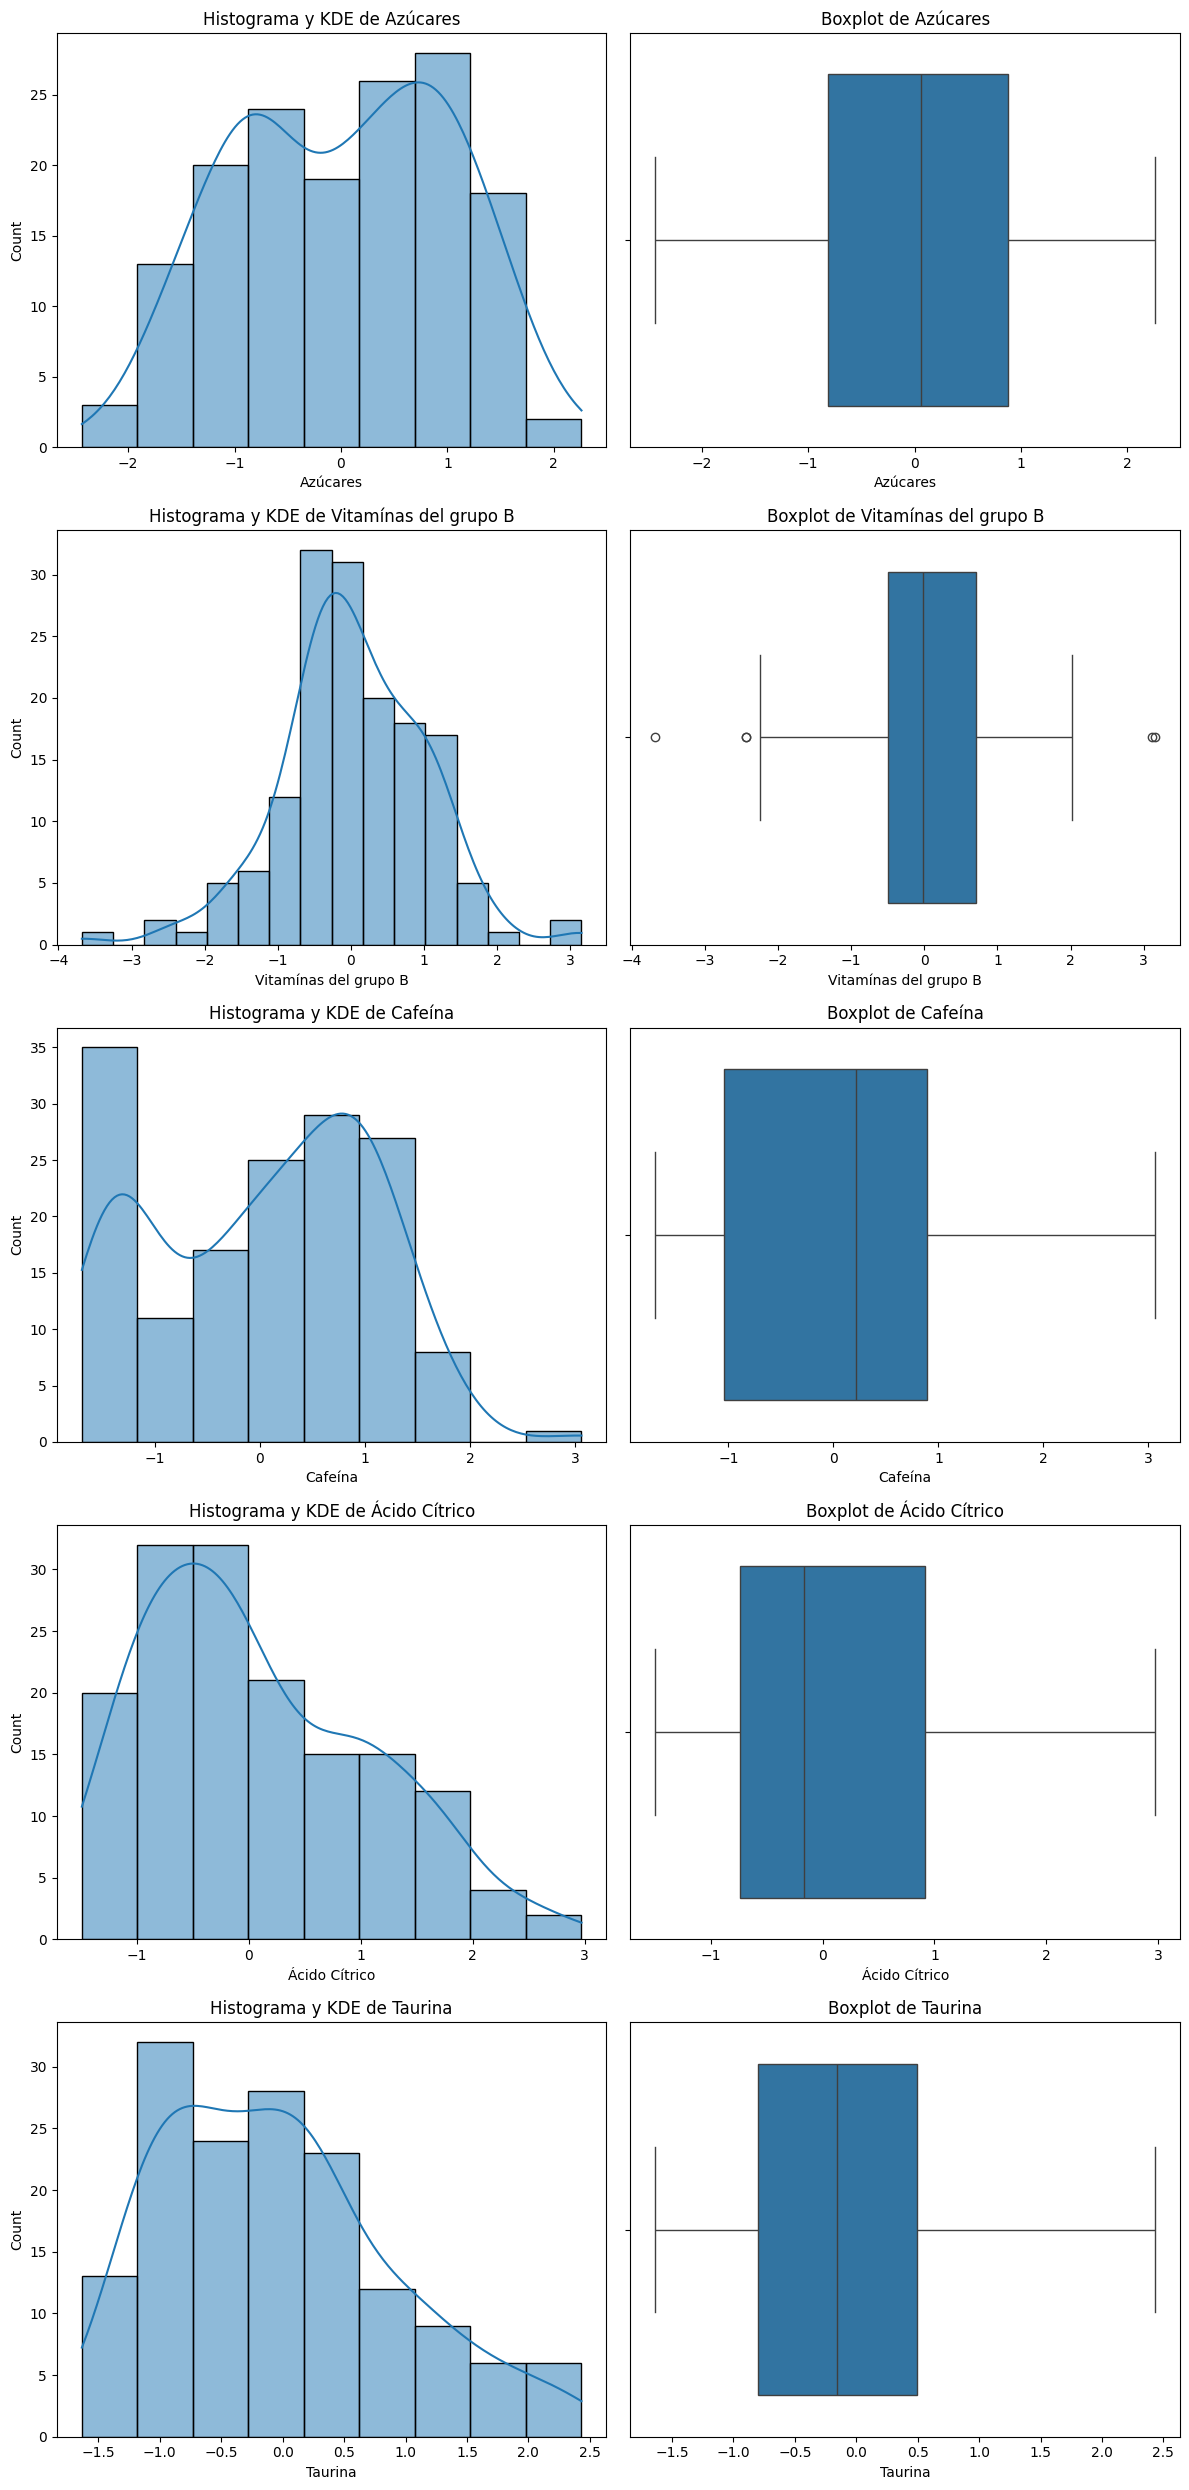

In [10]:
features0 = df.columns.to_list()

bt.plot_combined_graphs(df, features0)

Es poco común que las vitaminas por ejemplo tengan valores negativos...  es posible que estos valores negativos sean errores en la entrada de datos o algún tipo de anomalía?  
Sería prudente investigar más a fondo para determinar la causa de estos valores negativos y decidir que hacer con ellos.


In [11]:
# Contar cuántos valores negativos hay en la característica "Vitaminas del grupo B"
negativos_vitaminas = df[df['Vitamínas del grupo B'] < 0]
cantidad_negativos = negativos_vitaminas.shape[0]
print("Cantidad de valores negativos en la característica 'Vitaminas del grupo B':", cantidad_negativos)



Cantidad de valores negativos en la característica 'Vitaminas del grupo B': 78


-> Vitaminas del Grupo B tiene 78 valores negativos, lo que parecen anomalias?? Habria que preguntar a la empresa...de momento:
- vamos a reemplazar los valores negativos por sus valores absolutos, para cada variable
- Esto nos permitirá conservar la información en esos registros mientras corregimos el error en la entrada de datos.

In [12]:
def corregir_valores_negativos(df):
    # Iterar sobre todas las columnas del DataFrame
    for columna in df.columns:
        # Verificar si la columna tiene valores negativos
        if (df[columna] < 0).any():
            # Reemplazar los valores negativos por su valor absoluto
            df[columna] = np.abs(df[columna])
    return df

# Aplicar la función al DataFrame original
df_abs = corregir_valores_negativos(df)

# Verificar que no haya más valores negativos en ninguna variable
print("Valores negativos después de la corrección:")
print(df_abs[df_abs < 0].count())

Valores negativos después de la corrección:
Azúcares                 0
Vitamínas del grupo B    0
Cafeína                  0
Ácido Cítrico            0
Taurina                  0
dtype: int64


In [13]:
train_set = df_abs

In [42]:
features = train_set.columns.to_list()
features

['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

(5, 2)


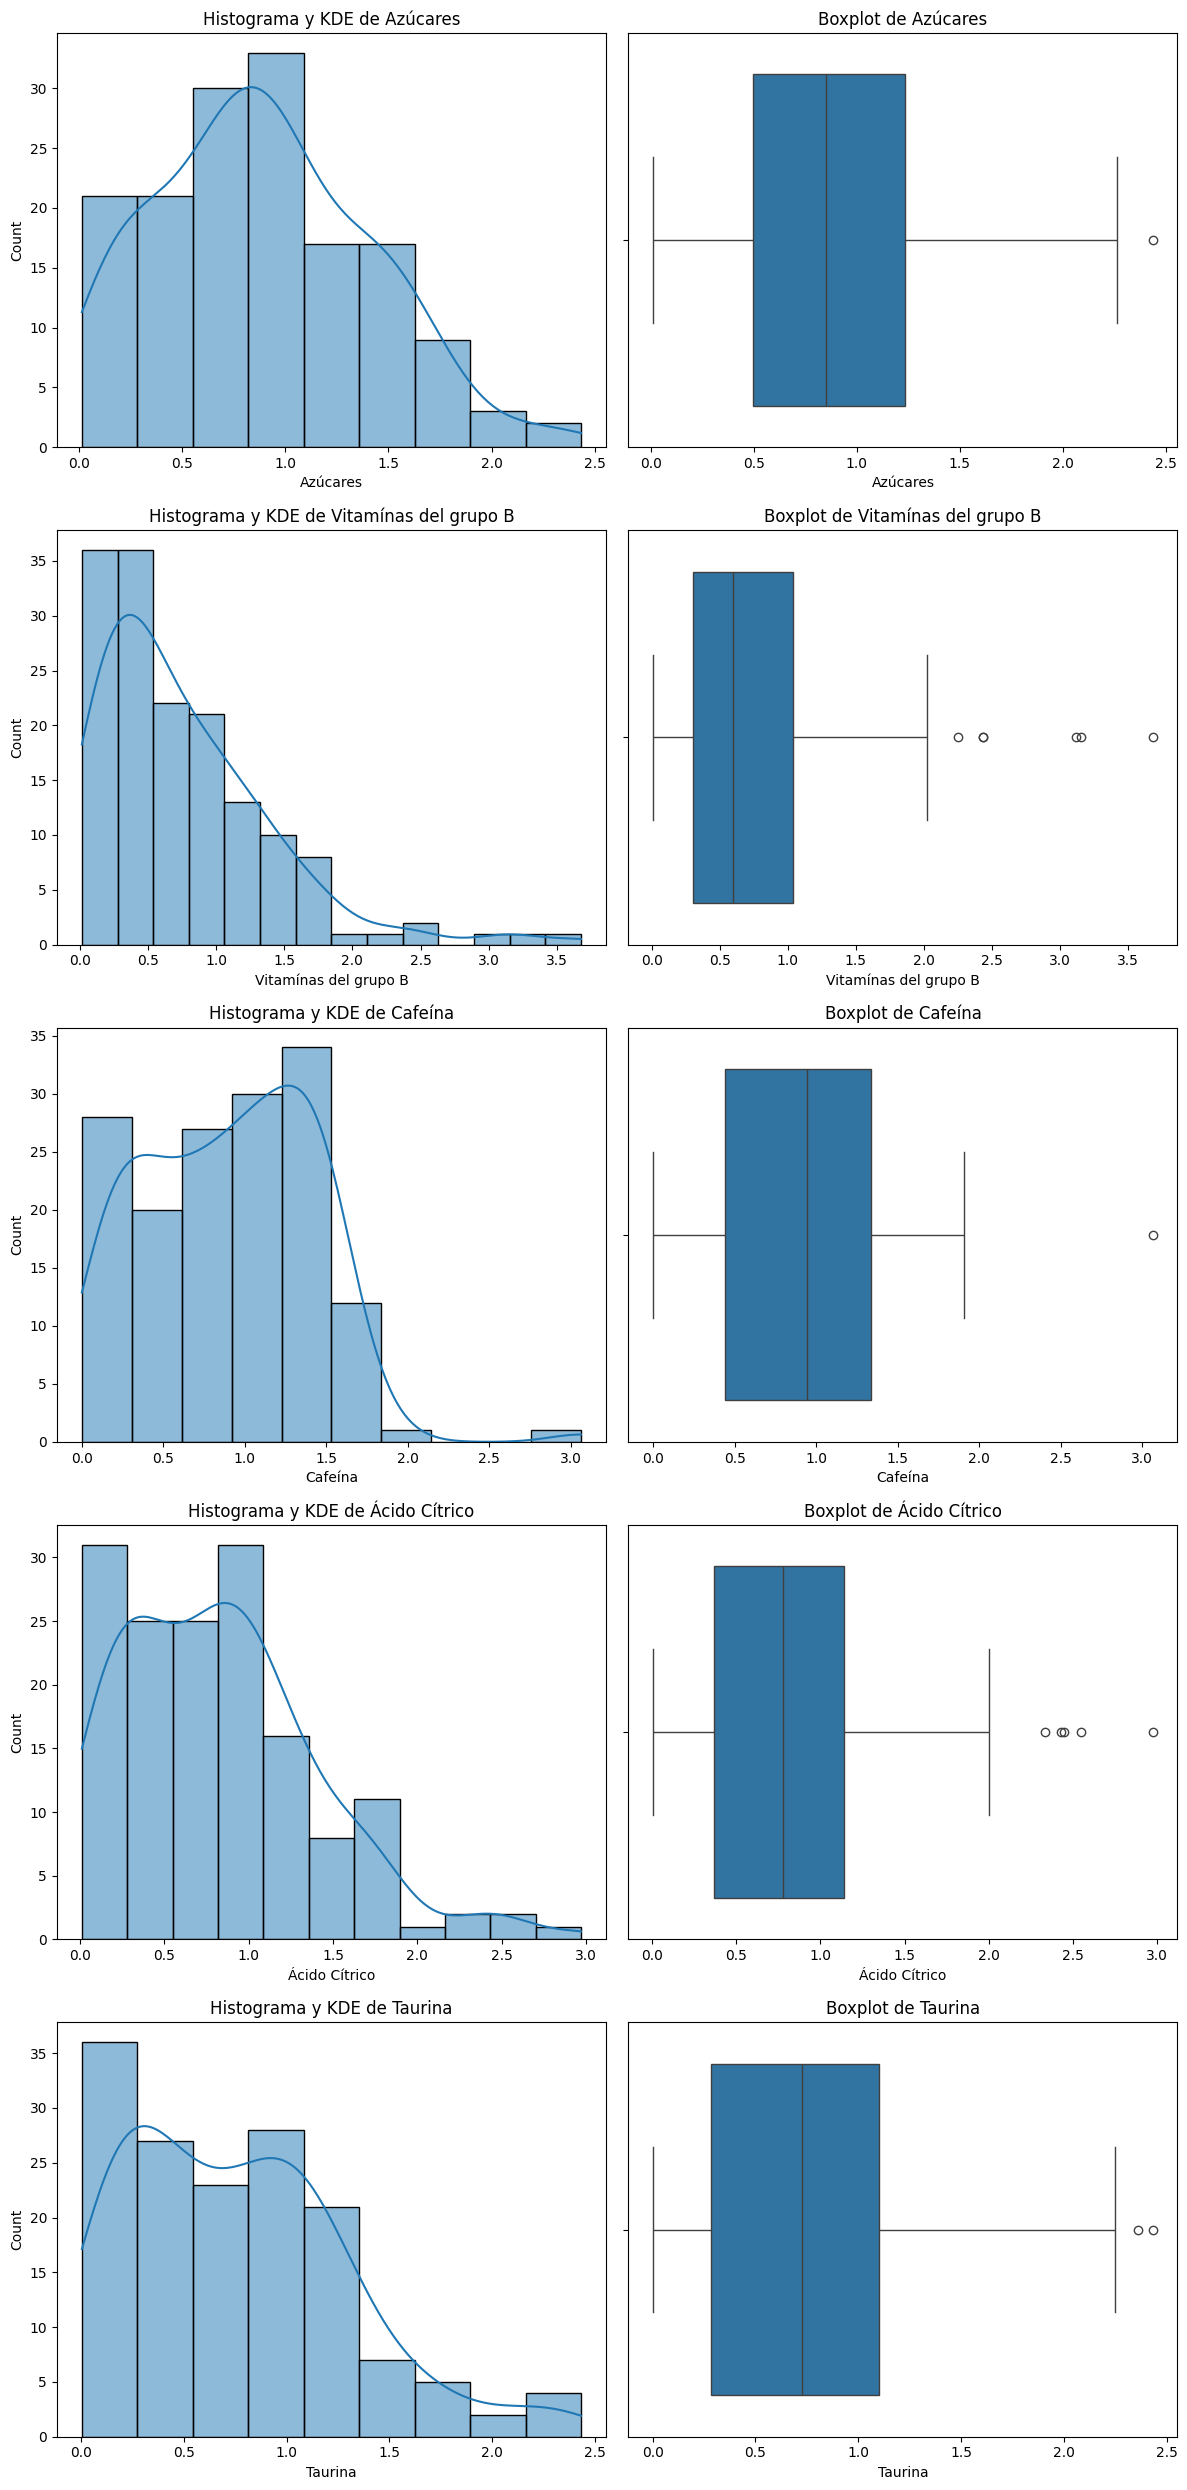

In [15]:
bt.plot_combined_graphs(train_set, features)

* habra que hacer unas manipulaciones con Vitamina del Grupo B... normalizar sobre todo, porque escalar no creo que haga falta porque ya tienen mas o menos la misma escala (pero recordemos que hay que ser vigilente con el tema de la escala porque el clustering es muy sensible a ello!)*

## Es hora de hacer el miniEDA.

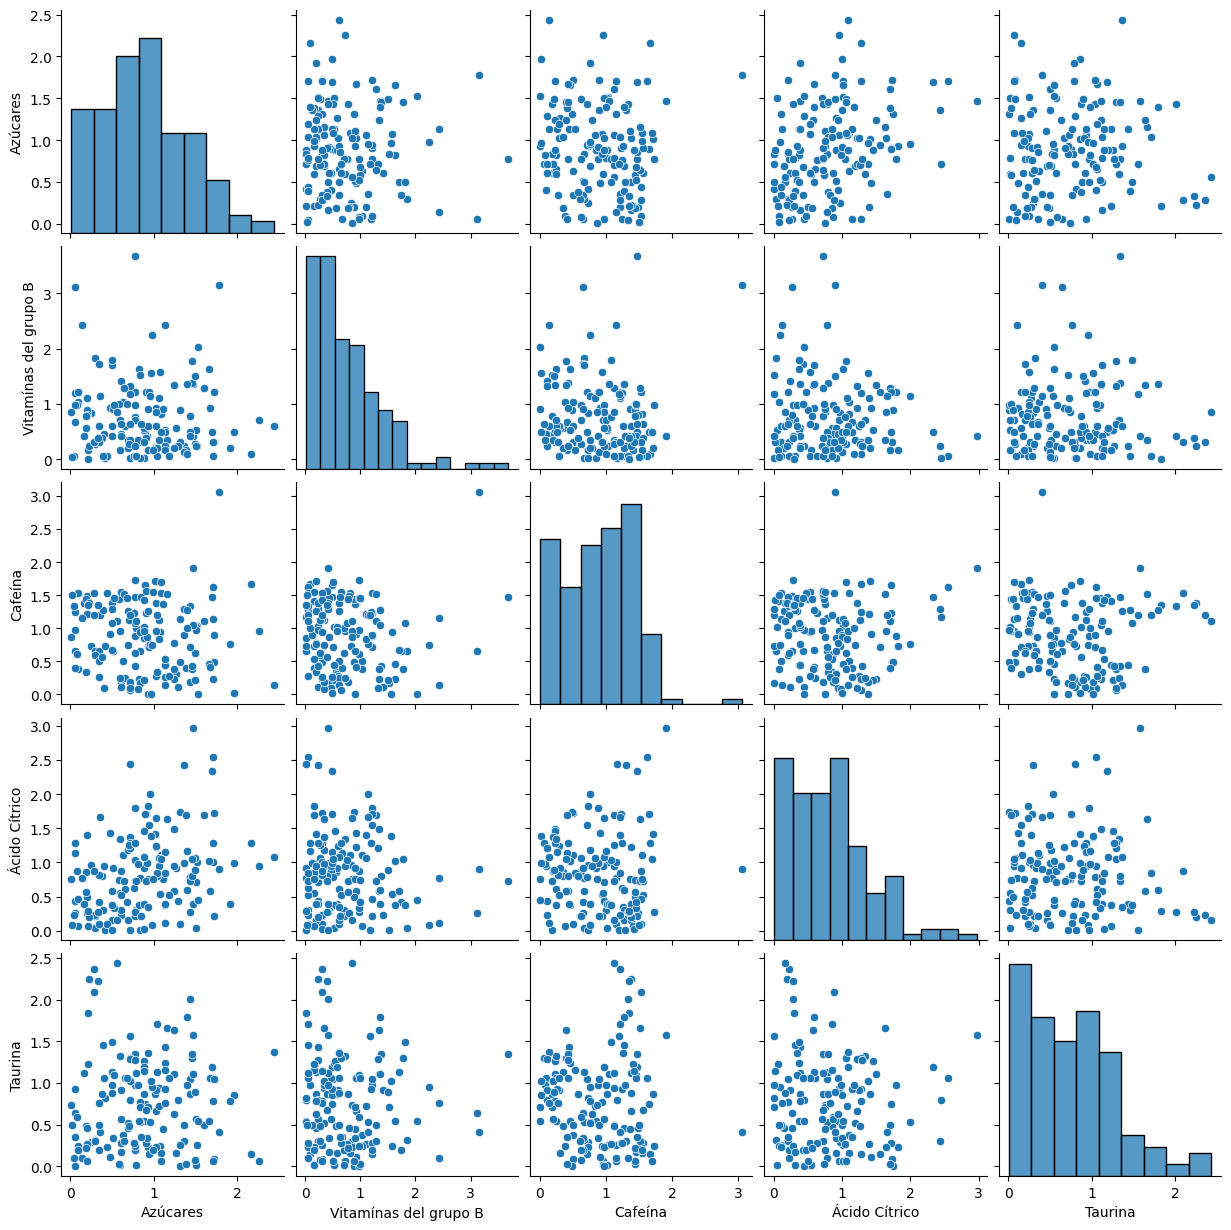

In [16]:
sns.pairplot(train_set[features])

Visto asi , no hay nada evidente...

In [21]:
df_norm = train_set.copy()


In [22]:
epsilon = 1e-9

# Aplicar logaritmo a la columna "Vitaminas del Grupo B" del DataFrame

df_norm['Vitamínas del grupo B'] = np.log(df_norm['Vitamínas del grupo B'] + epsilon)

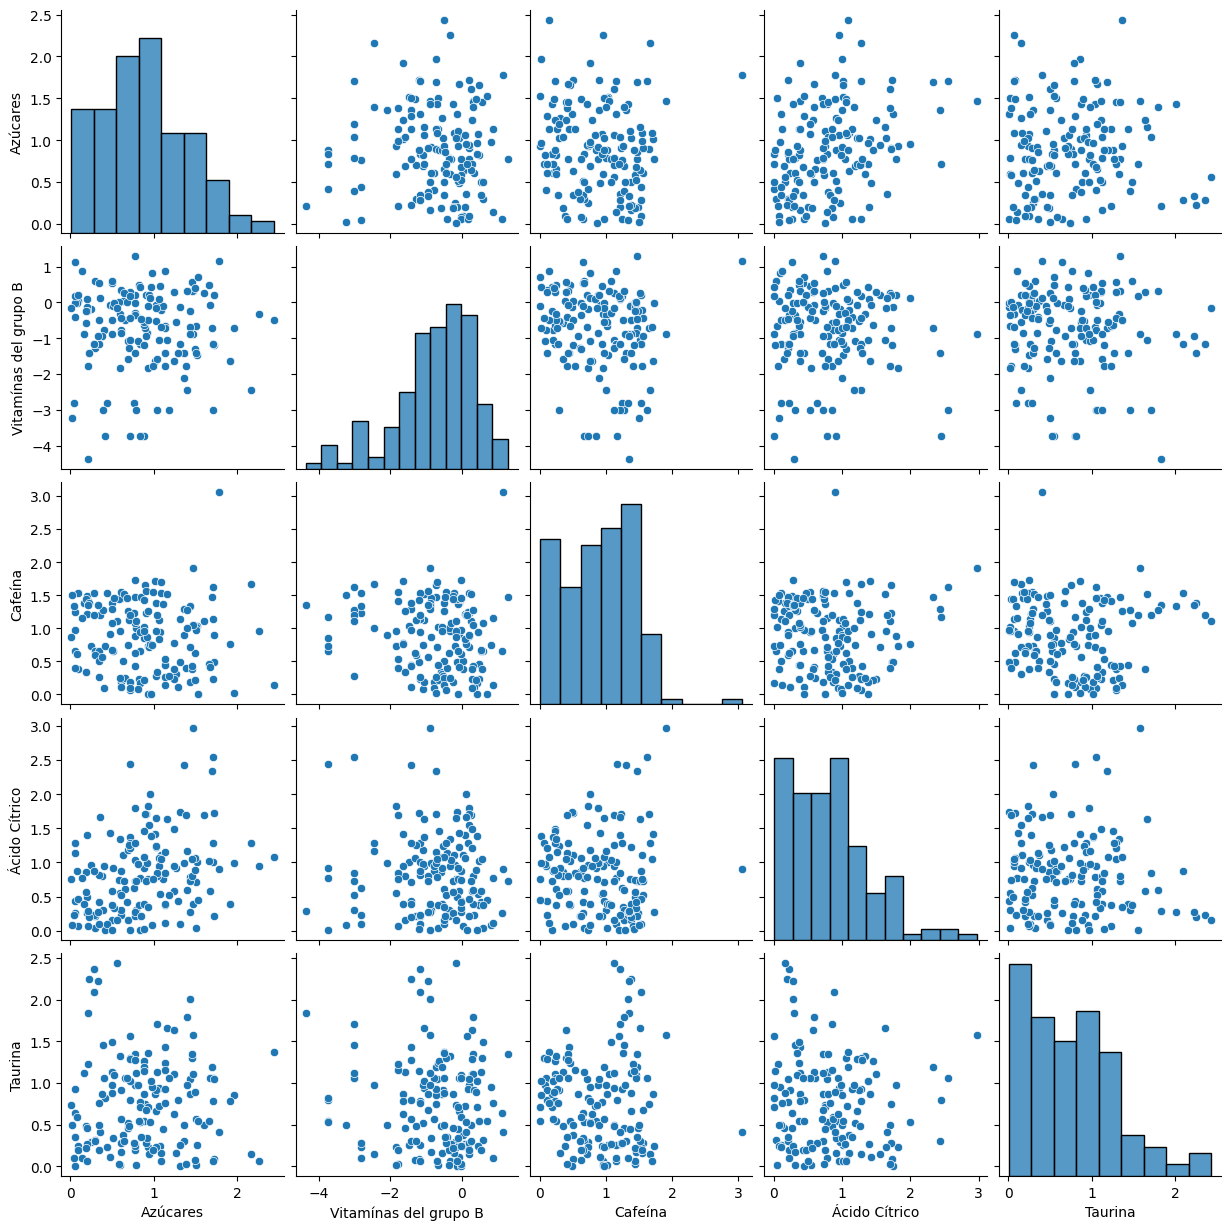

In [23]:
sns.pairplot(df_norm[features])

bt.plot_combined_graphs(df_norm, features)

# DBSCAN

In [27]:
from sklearn.cluster import DBSCAN 

In [29]:
outlier_percent = []

for eps in np.linspace(0.001,3,50): # Genera 50 valores equidistantes entre 0.001 y 3
    
    # Creamos el modelo
    dbscan = DBSCAN(eps=eps,min_samples=2*df_norm.shape[1]) # min_samples dos veces el ´numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
    dbscan.fit(df_norm)
   
     
    # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

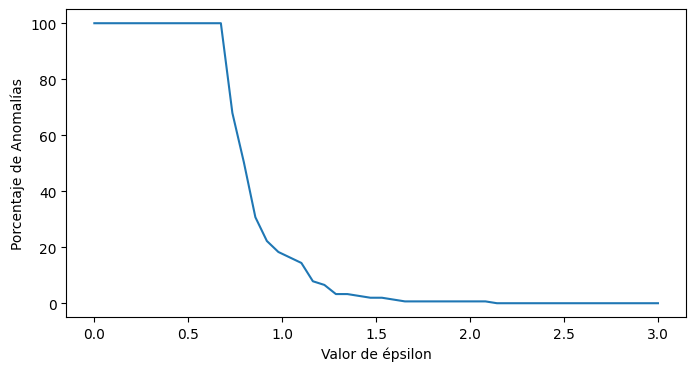

In [30]:
#Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

In [32]:
for indice,eps in [(indice,val) for indice,val in enumerate(np.linspace(0.001,3,50)) if 0.8 <= val <= 1.5]:
    print(f"Para {eps}: {outlier_percent[indice]}% de anomalías")

Para 0.8578571428571429: 30.718954248366014% de anomalías
Para 0.9190612244897959: 22.22222222222222% de anomalías
Para 0.980265306122449: 18.30065359477124% de anomalías
Para 1.041469387755102: 16.33986928104575% de anomalías
Para 1.1026734693877551: 14.379084967320262% de anomalías
Para 1.163877551020408: 7.8431372549019605% de anomalías
Para 1.2250816326530611: 6.5359477124183005% de anomalías
Para 1.2862857142857143: 3.2679738562091503% de anomalías
Para 1.3474897959183672: 3.2679738562091503% de anomalías
Para 1.4086938775510203: 2.6143790849673203% de anomalías
Para 1.4698979591836734: 1.9607843137254901% de anomalías


-> considerando como punto de parada un valor por debajo del 10%, eps = 1.15


In [33]:
dbscan2 = DBSCAN(eps=1.15)
dbscan2.fit(df_norm)

DBSCAN(eps=1.15)

In [36]:
dbscan.min_samples

10

In [37]:
df_norm['Labels'] = dbscan.labels_
df_norm['Labels'].value_counts()

Labels
0    153
Name: count, dtype: int64

mmmh, no ha ido bien...

# clustering jerarquico

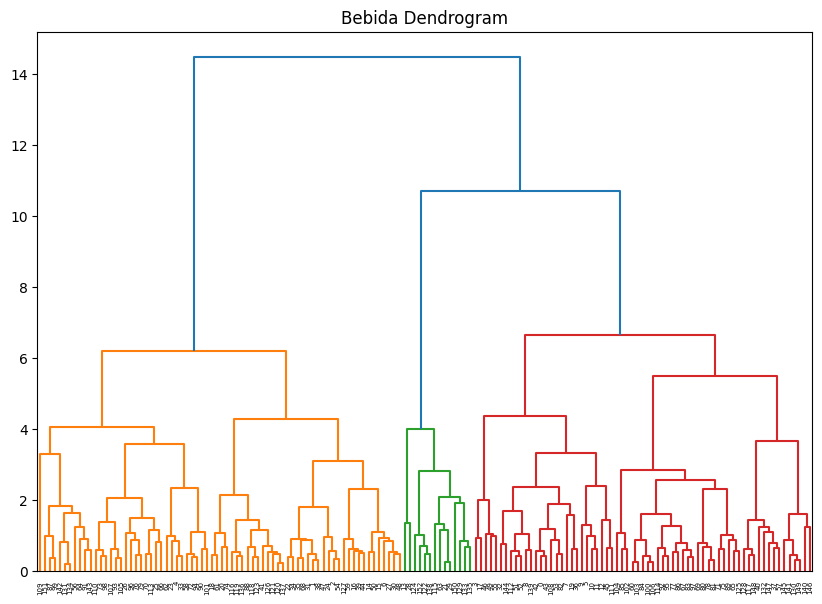

In [47]:
import scipy.cluster.hierarchy as shc # POUR VISUALISER LE DENDROGRAMME
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.title("Bebida Dendrogram")

selected_data = df_norm[['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']]
clusters = shc.linkage(selected_data, 
            method='ward', # Este hiperparámetro y el siguiente tienen que ver con la distancia entre clústeres y los veremos un poco más adelante
            metric="euclidean")
shc.dendrogram(Z=clusters)
plt.show()


**método del mayor salto (gap)** para encontrar el numero de clusters, aunque ya podemos observar que hay 3 (3 colores diferentes)

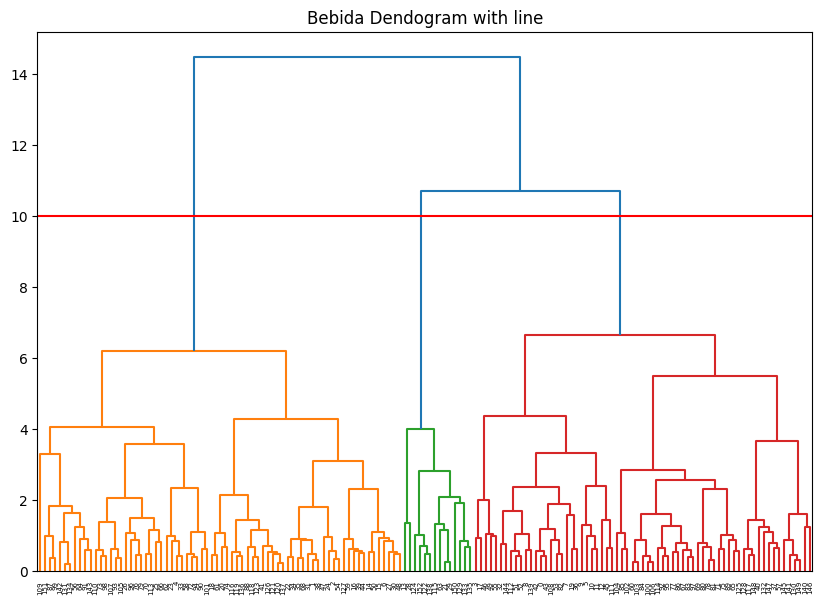

In [48]:
plt.figure(figsize=(10, 7))
plt.title("Bebida Dendogram with line")
clusters = shc.linkage(selected_data, 
            method='ward', 
            metric="euclidean")
shc.dendrogram(clusters)
plt.axhline(y = 10, color = 'r', linestyle = '-')

**metodo aglomerativo (abajo hacia arriba)**

In [46]:
from sklearn.cluster import AgglomerativeClustering

clustering_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='ward')
clustering_model.fit(selected_data)
clustering_model.labels_

array([1, 3, 3, 1, 4, 1, 3, 1, 1, 1, 1, 1, 1, 2, 3, 3, 3, 1, 3, 1, 3, 2,
       3, 4, 3, 4, 4, 3, 2, 2, 3, 3, 1, 4, 3, 3, 1, 0, 3, 3, 0, 3, 1, 1,
       3, 1, 1, 3, 3, 1, 3, 1, 1, 1, 3, 1, 4, 0, 4, 3, 0, 3, 4, 2, 4, 0,
       4, 0, 3, 0, 4, 0, 4, 4, 3, 0, 4, 0, 0, 4, 0, 0, 1, 0, 0, 0, 0, 4,
       3, 0, 4, 4, 0, 4, 4, 0, 4, 0, 4, 4, 0, 4, 0, 0, 0, 4, 0, 4, 1, 4,
       4, 1, 1, 4, 0, 2, 3, 0, 3, 3, 3, 3, 2, 3, 2, 0, 3, 3, 0, 2, 0, 4,
       0, 2, 4, 2, 3, 3, 2, 1, 0, 0, 4, 4, 1, 0, 0, 0, 0, 0, 2, 4, 2],
      dtype=int64)

Text(0.5, 1.0, 'Labeled Bebida Data')

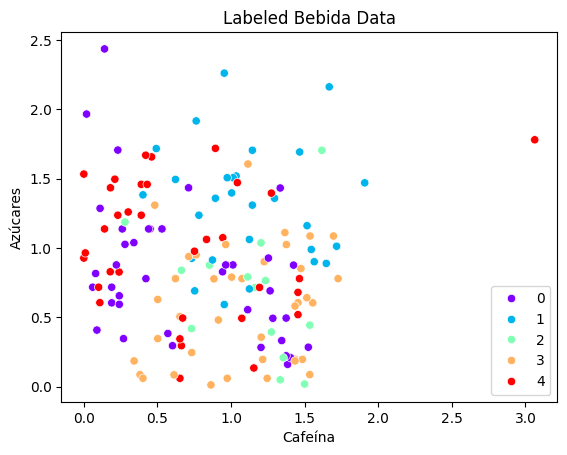

In [54]:
data_labels = clustering_model.labels_
sns.scatterplot(x='Cafeína', 
                y='Azúcares', 
                data=selected_data, 
                hue=data_labels, palette = "rainbow").set_title('Labeled Bebida Data')


### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.